In [204]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [205]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [206]:
image = cv2.imread('images/Donuts.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

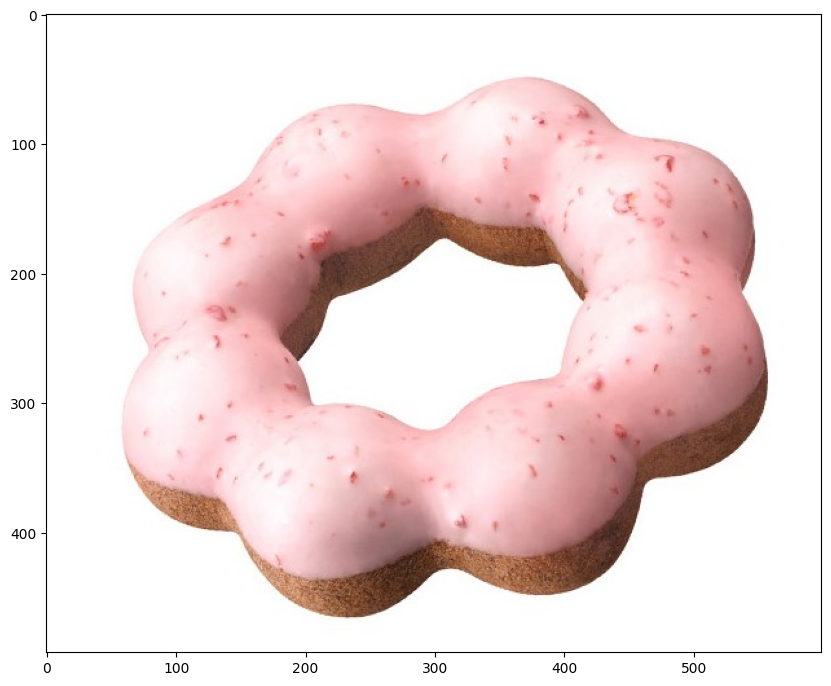

In [207]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [208]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [209]:
predictor.set_image(image)

In [222]:
input_point = np.array([[320, 350]])
input_label = np.array([1])

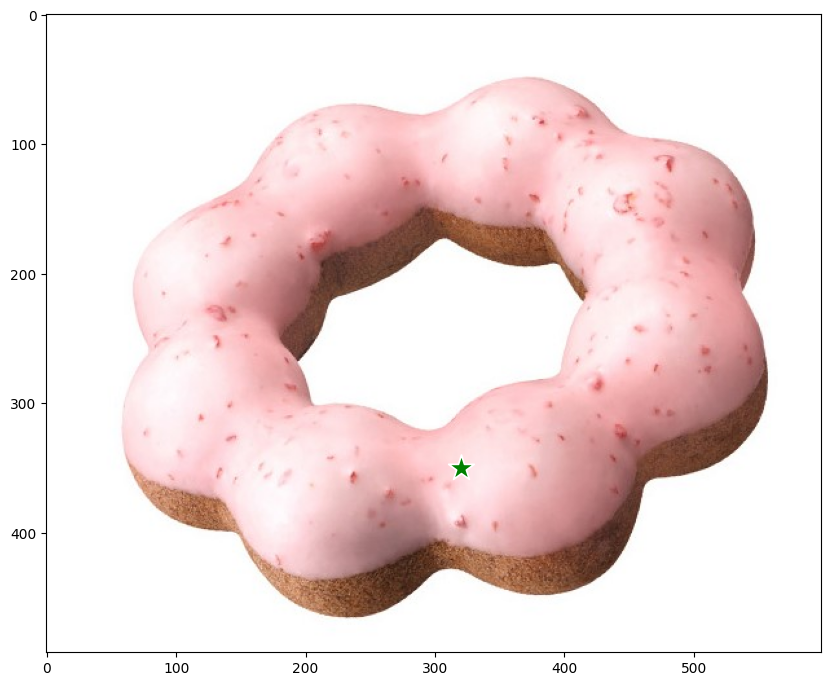

In [223]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [224]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [225]:
masks.shape

(3, 493, 599)

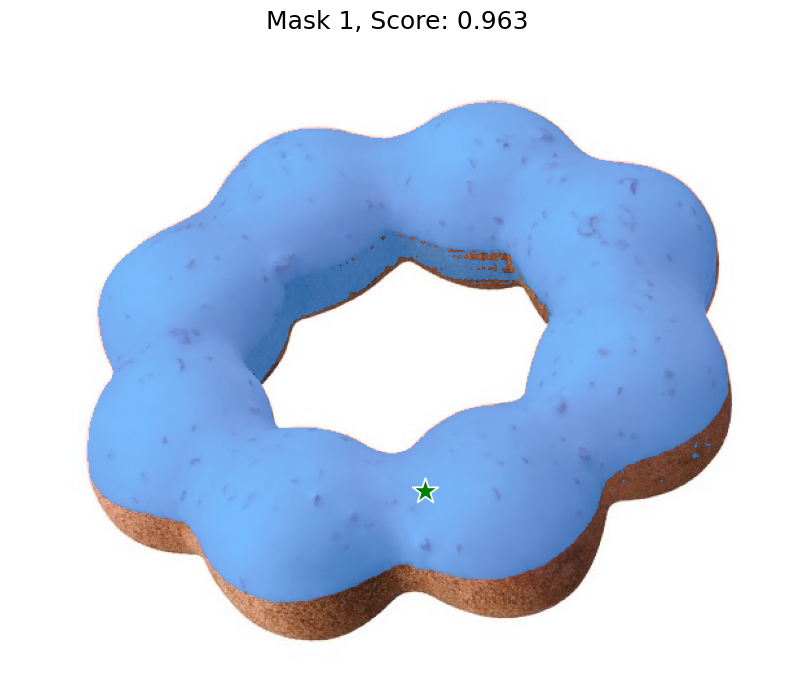

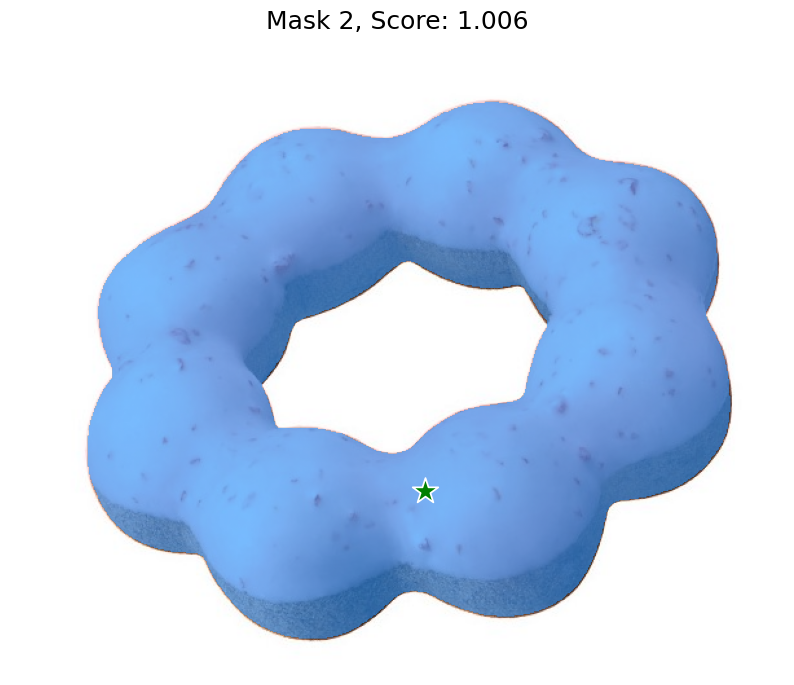

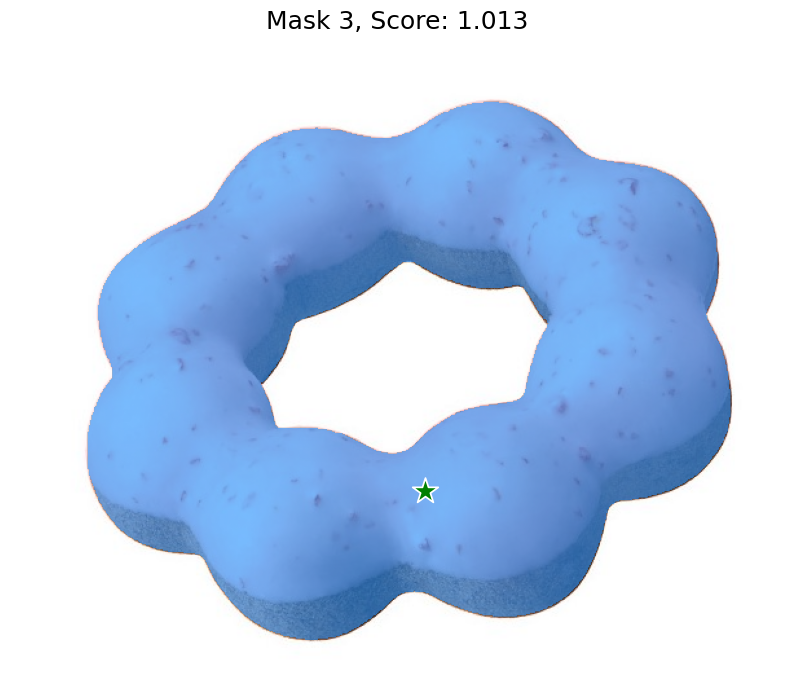

In [226]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

In [227]:
masks[1]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [228]:
import cv2
import numpy as np
from scipy.interpolate import splprep, splev

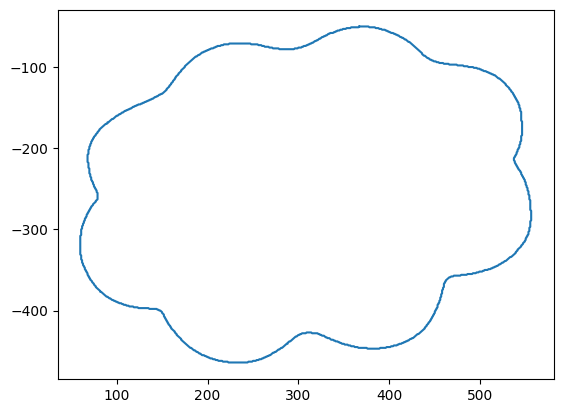

In [229]:
mask = masks[1].astype(np.uint8)*255
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0]
contour_points = np.concatenate([contour[:, 0, :],contour[:1, 0, :]],0)
# contour = contour[:, 0, :]
plt.plot(contour_points[:,0],-contour_points[:,1])
plt.show()

In [218]:
import numpy as np
from scipy.linalg import lstsq
from scipy.spatial import distance

def compute_arc_length_params(points):
    """
    計算弧長參數化的參數 t_i
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 弧长参数化后的参数列表 [t0, t1, ..., tn]
    """
    n = len(points)
    dists = [np.linalg.norm(np.array(points[i]) - np.array(points[i-1])) for i in range(1, n)]
    s = [0] + np.cumsum(dists).tolist()
    total_length = s[-1]
    t = [si / total_length for si in s]
    return t

def fit_bezier_curve(points):
    """
    拟合三次贝塞尔曲线
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :return: 控制点 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    """
    points = np.array(points)
    t = compute_arc_length_params(points)
    
    # 设定 P0 和 P3
    P0 = points[0]
    P3 = points[-1]
    
    # 构建矩阵 A 和向量 B
    A = []
    Bx = []
    By = []
    
    for i in range(1, len(points) - 1):
        ti = t[i]
        A.append([3 * (1 - ti)**2 * ti, 3 * (1 - ti) * ti**2])
        Bx.append(points[i, 0] - ((1 - ti)**3 * P0[0] + ti**3 * P3[0]))
        By.append(points[i, 1] - ((1 - ti)**3 * P0[1] + ti**3 * P3[1]))
    
    A = np.array(A)
    Bx = np.array(Bx)
    By = np.array(By)
    
    # 解最小二乘问题
    Px, _, _, _ = lstsq(A, Bx)
    Py, _, _, _ = lstsq(A, By)
    
    P1 = (Px[0], Py[0])
    P2 = (Px[1], Py[1])
    
    return [tuple(P0), P1, P2, tuple(P3)],t

# 示例样本点
points = [(1, 1), (2, 3), (4, 4), (6, 3), (7, 1)]
points = contour_points[376:382,:]

# 拟合贝塞尔曲线
control_points,points_t = fit_bezier_curve(points)
print("控制点: ", control_points)

ZeroDivisionError: division by zero

In [ ]:
def bezier_curve(t, p0, p1, p2, p3):
    """
    计算贝塞尔曲线上的点
    :param t: 参数t（0到1之间）
    :param p0: 控制点P0
    :param p1: 控制点P1
    :param p2: 控制点P2
    :param p3: 控制点P3
    :return: 贝塞尔曲线上的点
    """
    return (1-t)**3 * p0 + 3*(1-t)**2 * t * p1 + 3*(1-t) * t**2 * p2 + t**3 * p3

def compute_approximation_error(points, control_points, points_t):
    """
    计算逼近误差
    :param points: 样本点列表 [(x0, y0), (x1, y1), ..., (xn, yn)]
    :param control_points: 控制点列表 [(P0x, P0y), (P1x, P1y), (P2x, P2y), (P3x, P3y)]
    :return: 逼近误差
    """
    total_error = 0
    n = len(points)
    
    # 遍历样本点
    for point, t in zip(points,points_t):
        curve_point = bezier_curve(t, *control_points)
        dist = distance.euclidean(point, curve_point)
        total_error +=dist
    
    return total_error

loss=compute_approximation_error(points,np.array(control_points),points_t)
print(loss/len(points_t))

0.14124410438344184


In [ ]:
def contour_to_bezier_curves(contour_points,num=20):
    cl = contour_points.shape[0]
    points = contour_points
    control_points,points_t = fit_bezier_curve(points)
    control_points_set = [control_points]
    loss=compute_approximation_error(points,np.array(control_points),points_t)
    split_points_and_loss = [[0,cl-1,loss]]
    while len(control_points_set)<num:
        max_loss=0
        max_loss_index=0
        for i in range(len(split_points_and_loss)):
            if max_loss<split_points_and_loss[i][2]:
                max_loss=split_points_and_loss[i][2]
                max_loss_index=i
        split_points_and_loss_t=split_points_and_loss[max_loss_index]
        split_points_and_loss.pop(max_loss_index)
        control_points_set.pop(max_loss_index)
        mt=int((split_points_and_loss_t[0]+split_points_and_loss_t[1])//2)
        t1=split_points_and_loss_t[0]
        t2=mt
        points = contour_points[t1:t2+1]
        control_points,points_t = fit_bezier_curve(points)
        control_points_set.insert(max_loss_index,control_points)
        loss=compute_approximation_error(points,np.array(control_points),points_t)
        split_points_and_loss.insert(max_loss_index,[t1,t2,loss])
        t1=mt
        t2=split_points_and_loss_t[1]
        points = contour_points[t1:t2+1]
        control_points,points_t = fit_bezier_curve(points)
        control_points_set.insert(max_loss_index+1,control_points)
        loss=compute_approximation_error(points,np.array(control_points),points_t)
        split_points_and_loss.insert(max_loss_index+1,[t1,t2,loss])

    return control_points_set
control_points_set = contour_to_bezier_curves(contour_points)

In [ ]:
def write_svg(filename,control_points_set,rgb):
    with open(filename, 'w') as f:
        f.write('<svg xmlns="http://www.w3.org/2000/svg" width="100%" height="100%">\n')
        control_points = control_points_set[0]
        f.write('<path d="M {:.2f} {:.2f} '.format(control_points[0][0], control_points[0][1]))
        for control_points in control_points_set:
            f.write('C {:.2f} {:.2f}, {:.2f} {:.2f}, {:.2f} {:.2f} '.format(control_points[1][0], control_points[1][1],control_points[2][0], control_points[2][1], control_points[3][0],control_points[3][1]))
        f.write('Z" fill="rgb('+str(rgb[0])+','+str(rgb[1])+','+str(rgb[2])+')" />\n')
        f.write('</svg>')
write_svg('bezier_curves.svg', control_points_set,[255,0,0])